In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(333)

df = pd.read_csv('./data/merged_probs_odds.csv') # labels: "home wins" -> 1; "draw": 0; "away" -> -1
df.tail()
df = df.sort_values("date_x", ascending = True)

In [11]:
from tqdm import tqdm

def make_trajectories(df, trajectory_len=30, keep_cols=['spi1', 'spi2', 'prob_home', 'prob_tie', 'prob_away', 'odds_home', 'odds_draw', 'odds_away',
                                                        'proj_home_score', 'proj_away_score', 'home_goals', 'away_goals', 'label']):
    num_traj = int(df.shape[0] // trajectory_len)
    trajectories = []
    for i in tqdm(range(num_traj)):
        df = df.sample(frac=1.0) # shuffle
        traj = df.iloc[:trajectory_len] # keep first {traj_len} random games
        traj = traj.sort_values(by='date_x', ascending=True) # make game sample chronologic
        trajectories.append(traj)
    return trajectories

In [12]:
rename_dict = {"odds_home": "home", "odds_draw": "draw", "odds_away": "away", "label": "result"}

odds_df = df[["date_x", "home_team", "away_team", "odds_home", "odds_draw", "odds_away", "label"]].rename(rename_dict, axis = 1)
odds_df['result'] = odds_df['result'].map({1: 0, -1: 2, 0: 1})

In [13]:
traj_list = make_trajectories(odds_df, keep_cols = ["home_team", "away_team", "odds_home", "odds_draw", "odds_away", "label"])

100%|██████████| 358/358 [00:00<00:00, 671.32it/s]


In [14]:
train_list = traj_list[:300]
test_list = traj_list[300:]

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

train_df

,date_x,home_team,away_team,home,draw,away,result
544,2017-08-09,Ponte Preta,Fluminense,2.17,3.27,3.29,1
812,2017-09-16,Guingamp,Lille,2.15,3.30,3.50,0
970,2017-09-30,Udinese,Sampdoria,2.70,3.25,2.60,0
2073,2018-08-15,Vissel Kobe,Sanfrecce Hiroshima,2.42,3.40,2.78,1
2271,2018-09-02,Albacete,Cordoba,1.95,3.10,4.33,0
...,...,...,...,...,...,...,...
8884,2022-06-24,Internacional,Coritiba,1.76,3.57,4.70,0
9052,2022-08-03,Portland Timbers,Nashville SC,2.22,3.56,3.03,1
9725,2022-10-01,Ajax,Go Ahead Eagles,1.08,11.29,25.19,1
9971,2022-10-16,Real Madrid,Barcelona,2.28,3.64,3.05,0


In [15]:
from oddsgym.envs.soccer import ThreeWaySoccerOddsEnv
from oddsgym.envs.base_percentage import BasePercentageOddsEnv

Trial #1: Bet fixed amounts alway on a home win

Sources: 

https://colab.research.google.com/drive/1eqODB6TYWUaPq-SG1LD8kVcw1VMqEUyU#scrollTo=juMw2p58Jv8r

https://oryjonay.github.io/Odds-Gym/

In [16]:
#Test model and append total ending rewards 
eps_length = test_list[0].shape[0]
num_traj = len(test_list)
rewards = []

for i in range(num_traj):
    env = ThreeWaySoccerOddsEnv(test_list[i], starting_bank = 1000)
    env.reset()
    for l in range(eps_length):
        #print(env.render())
        obs, reward, done, info = env.step(1)
        if done:
            rewards.append(info['balance'])
            break

print(sum(rewards)/len(rewards))
print(max(rewards))

996.296379310345
1012.2300000000001


Trial #2: Bet fixed amounts always randomly

In [17]:
#Test model and append total ending rewards 
eps_length = test_list[0].shape[0]
num_traj = len(test_list)
rewards = []

for i in range(num_traj):
    env = ThreeWaySoccerOddsEnv(test_list[i])
    env.reset()
    for l in range(eps_length):
        #print(env.render())
        obs, reward, done, info = env.step(env.action_space.sample())
        if done:
            rewards.append(info['balance'])
            break

print(sum(rewards)/len(rewards))
print(max(rewards))

7.971724137931034
26.209999999999994


Trial #3: Bet percentage amounts always randomly

In [18]:
INITS = 1000

In [19]:
#Test model and append total ending rewards 
eps_length = test_list[0].shape[0]
num_traj = len(test_list)
rewards = np.zeros((num_traj, INITS))

for j in range(INITS):
    for i in range(num_traj):
        odds_df = test_list[i][["home", "draw",	"away"]].to_numpy()
        results_df = test_list[i]["result"].tolist()
        env = BasePercentageOddsEnv(odds_df, ["home", "draw", "away"], results_df, starting_bank=1000)
        env.reset()
        for l in range(eps_length):
            #print(env.render())
            action = env.action_space.sample()
            obs, reward, done, info = env.step(action)
            if done:
                rewards[i][j] = info['balance']
                break

rewards = np.mean(rewards, axis = 1)
print(sum(rewards)/rewards.shape[0])
print(max(rewards))

/Users/bryanchia/opt/anaconda3/envs/cs224r_project/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


775.3349406831412
1601.3880114567135


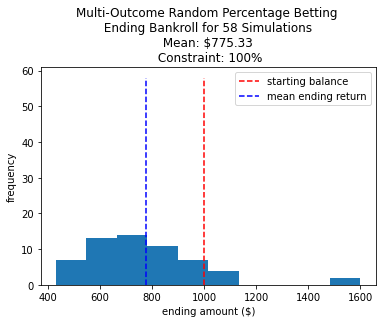

In [20]:
mean_return = round(np.mean(rewards), 2)
NUM_SIMULATIONS = len(rewards)
CONSTRAINT = 1
plt.hist(rewards)
plt.title(f'Multi-Outcome Random Percentage Betting \n Ending Bankroll for {NUM_SIMULATIONS} Simulations \n Mean: ${mean_return} \n Constraint: {100*CONSTRAINT}%')
plt.plot([1000, 1000], [0, NUM_SIMULATIONS], 'r--', label='starting balance')
plt.plot([mean_return, mean_return], [0, NUM_SIMULATIONS], 'b--', label='mean ending return')
plt.legend(loc='best')
plt.xlabel('ending amount ($)')
plt.ylabel('frequency')
plt.show()

Trial #4: Fixed Baselines, train policy using PPO2

Sources:

https://colab.research.google.com/drive/1eqODB6TYWUaPq-SG1LD8kVcw1VMqEUyU#scrollTo=juMw2p58Jv8r 

https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/3_multiprocessing.ipynb#scrollTo=AvO5BGrVv2Rk 

https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html

In [21]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines import PPO2
from stable_baselines.common import set_global_seeds

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/Users/bryanchia/opt/anaconda3/envs/cs224r_project/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [22]:
def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        env = ThreeWaySoccerOddsEnv(train_list[env_id])
        # Important: use a different seed for each environment
        env.seed(seed + rank)
        return env
    set_global_seeds(seed)
    return _init

In [23]:
#Train model and append total ending rewards 
eps_length = train_list[0].shape[0]
num_traj = len(train_list)
rewards = []

learning_env = DummyVecEnv([make_env(i, i) for i in range(num_traj)])
model = PPO2(MlpPolicy, learning_env, verbose=1)
obs = learning_env.reset()
print(model.action_probability(obs))
model.learn(total_timesteps=3000)






Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



[[0.12498855 0.12528048 0.12514114 ... 0.12551267 0.1246426  0.12451547]
 [0.1250485  0.12558624 0.12505959 ... 0.12475454 0.12494054 0.12421407]
 [0.12502126 0.12515979 0.12527171 ... 0.12575656 0.12454916 0.12460402]
 ...
 [0.12574993 0.12469894 0.12595485 ... 0.12626122 0.12430038 0.12453921]
 [0.12537202 0.12488899 0.12575236 ... 0.12624873 0.12433683 0.12466716]
 [0.12502609 0.12513088 0.12531522 ... 0.12582915 0.12451967 0.12462526]]


In [24]:
#Test model and append total ending rewards 
eps_length = test_list[0].shape[0]
num_traj = len(test_list)
rewards = []

for i in range(num_traj):
    env = ThreeWaySoccerOddsEnv(test_list[i])
    obs = env.reset()
    for l in range(eps_length):
        #print(env.render())
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        if done:
            rewards.append(info['balance'])
            break

print(sum(rewards)/len(rewards))
print(max(rewards))

6.9382758620689655
22.47


Trial #5: Percentage Baselines, train policy using PPO2

In [25]:
def make_perc_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        odds_df = train_list[env_id][["home", "draw",	"away"]].to_numpy()
        results_df = train_list[env_id]["result"].tolist()
        env = BasePercentageOddsEnv(odds_df, ["home", "draw", "away"], results_df)
        # Important: use a different seed for each environment
        env.seed(seed + rank)
        return env
    set_global_seeds(seed)
    return _init

In [26]:
#Train model and append total ending rewards 
eps_length = train_list[0].shape[0]
num_traj = len(train_list)
rewards = []

learning_env = DummyVecEnv([make_perc_env(i, i) for i in range(num_traj)])
model = PPO2(MlpPolicy, learning_env, verbose=1)
obs = learning_env.reset()
model.learn(total_timesteps=3000)

/Users/bryanchia/opt/anaconda3/envs/cs224r_project/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [27]:
#Test model and append total ending rewards 
eps_length = test_list[0].shape[0]
num_traj = len(test_list)
rewards = np.zeros((num_traj, INITS))

for j in range(INITS):
    for i in range(num_traj):
        odds_df = test_list[i][["home", "draw",	"away"]].to_numpy()
        results_df = test_list[i]["result"].tolist()
        env = BasePercentageOddsEnv(odds_df, ["home", "draw", "away"], results_df, starting_bank=1000)
        obs = env.reset()
        for l in range(eps_length):
            #print(env.render())
            action, _states = model.predict(obs)
            obs, reward, done, info = env.step(action)
            if done:
                rewards[i][j] = info['balance']
                break

rewards = np.mean(rewards, axis = 1)
print(sum(rewards)/rewards.shape[0])
print(max(rewards))

889.9686587737638
1163.4046425824938


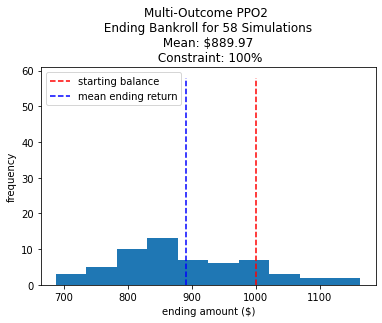

In [28]:
mean_return = round(np.mean(rewards), 2)
NUM_SIMULATIONS = rewards.shape[0]
CONSTRAINT = 1
plt.hist(rewards)
plt.title(f'Multi-Outcome PPO2 \n Ending Bankroll for {NUM_SIMULATIONS} Simulations \n Mean: ${mean_return} \n Constraint: {100*CONSTRAINT}%')
plt.plot([1000, 1000], [0, NUM_SIMULATIONS], 'r--', label='starting balance')
plt.plot([mean_return, mean_return], [0, NUM_SIMULATIONS], 'b--', label='mean ending return')
plt.legend(loc='best')
plt.xlabel('ending amount ($)')
plt.ylabel('frequency')
plt.show()

Trial #6: Percentage Baselines, train policy using PPO2, adding a 10% constraint

In [29]:
def make_perc_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        odds_df = train_list[env_id][["home", "draw",	"away"]].to_numpy()
        results_df = train_list[env_id]["result"].tolist()
        env = BasePercentageOddsEnv(odds_df, ["home", "draw", "away"], results_df)
        # Important: use a different seed for each environment
        env.seed(seed + rank)
        return env
    set_global_seeds(seed)
    return _init

In [30]:
#Train model and append total ending rewards 
eps_length = train_list[0].shape[0]
num_traj = len(train_list)
rewards = []

learning_env = DummyVecEnv([make_perc_env(i, i) for i in range(num_traj)])
model = PPO2(MlpPolicy, learning_env, verbose=1)
obs = learning_env.reset()
model.learn(total_timesteps=3000)